In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
from src.federated_pipeline import Federated

In [3]:
federated = Federated(
    "CONFIG_MODEL.json",
    "CONFIG_FEDERATED.json"
)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


 30%|███       | 3/10 [00:00<00:00, 29.35it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


100%|██████████| 1295/1295 [00:05<00:00, 246.58it/s]


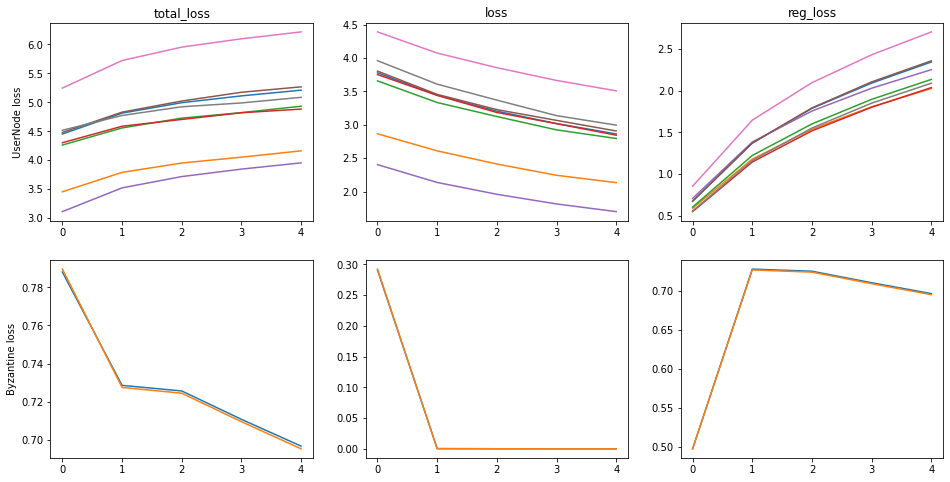

In [4]:
federated.train(5)

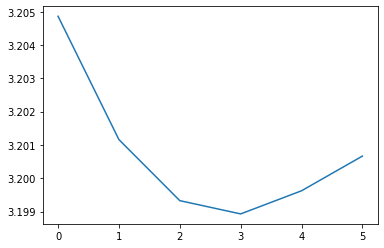

In [5]:
plt.plot(federated.general_model_val_losses.values())

In [6]:
federated.generate_general('trump')

'trump brags about being a sexual predator he nevertrump me now my old boss doesnt keep me despicable in other publicity ah so thats right thats why hes the only thing cheated on me but sir i were mad at the audio of trump admitting rape culture is good to leaders hrc has spent years ago etc wtf is she said shed be ashamed of things around yourself new g social security co realdonaldtrump w trum top finds wife and a killed christian supremacist donors are my th numbers we know what they were around all they are terrified of hillarys'

In [7]:
federated.generate_node('trump', 1)

'trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump'

In [8]:
federated.generate_node('trump', 2)

'trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump'

In [9]:
federated.generate_node('trump', 5)

'trump said trump loves women but she doesnt quit stamina and square questions with her husbands encounters with her husband in the oval office but blaming her husbands remarks about decades controversy is involved in christians her column was a powerful indictment of planned parenthood actively colluding with the people to find libya with donald roger ailes and declined donald trump to withdraw directly from inside united states in new york th graphic hrc video julian speech transcripts were simultaneously breaking the working thing for his supporters have how to see me been ready to hear another month until day until'

In [10]:
federated.generate_node('trump', 7)

'trump slams hollywood for blaming innocent teens used to be like the central park five are forgotten because he is against influences the debate now screw them the democrat elected shes gonna get elected has is doing no drama rather than kaine is supposed to win this is just deplorable that politics is what we need to take shows you now hes going anywhere lets solve it all interesting vi my client and put on call out hrc amp calls illegal immigrants speak out doesnt matter what trump foundation did abt me is so our president in order to get bored'

In [11]:
assert False

AssertionError: 

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
d = 2
N = 20000

mu_0, sigma_0 = [-1.5] * int(N / 2), 0.8
mu_1, sigma_1 = [ 1.5] * int(N / 2), 0.8

In [3]:
data_0 = sigma_0 * np.random.randn(d, int(N / 2)) + mu_0
data_1 = sigma_1 * np.random.randn(d, int(N / 2)) + mu_1

labels_0 = [0] * int(N / 2)
labels_1 = [1] * int(N / 2)

In [4]:
data = np.concatenate((data_0.T, data_1.T))
labels = np.concatenate((labels_0, labels_1))

In [5]:
data = np.column_stack((data, labels))
np.random.shuffle(data)

In [6]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = np.column_stack((data.shape[0] * [1], data))
        self.labels = labels
        
    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.FloatTensor([self.labels[idx]])
    
    def __len__(self):
        return len(self.labels)
    
dataset = SimpleDataset(data[:,:2], data[:,2])

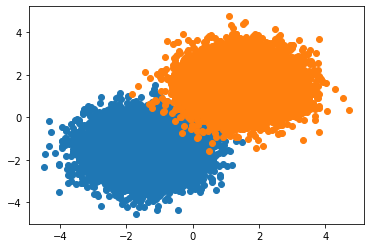

In [7]:
plt.scatter(data_0[0,:], data_0[1,:])
plt.scatter(data_1[0,:], data_1[1,:])
plt.show()

In [8]:
class Node():
    def __init__(self, data):
        self.data = SimpleDataset(data[:,:2], data[:,2])
        self.c = data.shape[0]
        
n_nodes = 100
m = int(N / n_nodes)

nodes = []
for n in range(n_nodes):
    a,b = int(n * m), int((n+1) * m)
    nodes.append(Node(data[a:b]))

In [10]:
class SimpleModel(torch.nn.Module):
    def __init__(self, length):
        super().__init__()
        self.length = length
        self.vector = torch.nn.Parameter(
            torch.tensor([-0.5] * length),
            requires_grad = True
        )
        
    def forward(self, x):
        x = torch.matmul(x, self.vector.reshape(self.length, -1))
        return torch.sigmoid(x)
    
    def save_model(self, name = 'simple_model.pth'):
        torch.save(self.state_dict(), name)
    
    def load_model(self, name = 'simple_model.pth'):
        self.load_state_dict(torch.load(name))
        
    def fit(self, dataloader, epochs):
        self.train()
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        
        for i in range(epochs):
            for x,y in dataloader:
                x = self(x)
                loss = criterion(x, y)
                loss.backward()
                optimizer.step()
            
    def evaluate(self, dataloader):
        self.eval()
        acc = []
        with torch.no_grad():
            for x,y in dataloader:
                x = (self.forward(x) < 1/2)
                acc.append(torch.abs(y - x * 1).sum().item() / dataloader.batch_size)
        return np.mean(acc)

In [13]:
EPOCHS = 3

simple_model = SimpleModel(3)
simple_model.save_model()
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 4,
    shuffle = True,
    drop_last = True
)
simple_model.evaluate(dataloader)

0.01865

## Normal Learning

In [14]:
simple_model.fit(dataloader, EPOCHS)
simple_model.evaluate(dataloader)

0.99545

## Federated Learning

### FedSGD

In [15]:
name = 'simple_fed_SDG.pth'

simple_model = SimpleModel(3)
simple_model.load_model()
simple_model.save_model(name)
simple_model.evaluate(dataloader)

0.01865

In [18]:
agg_state_dict = None

for e in tqdm(range(EPOCHS)):
    total = sum([n.c for n in nodes])
    for node in nodes:
        simple_model.load_model(name = name)
        node_dataloader = torch.utils.data.DataLoader(
            node.data,
            batch_size = 4,
            shuffle = True,
            drop_last = True
        )
        simple_model.fit(node_dataloader, 1)
        if agg_state_dict is None:
            agg_state_dict = simple_model.state_dict() * node.c / total
        else:
            node_state_dict = simple_model.state_dict()
            for key in agg_state_dict:
                agg_state_dict[key] = agg_state_dict[key] + node_state_dict[key] * node.c / total
                
    simple_model.load_state_dict(agg_state_dict)
    simple_model.save_model(name)
    
simple_model.evaluate(dataloader)

100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


0.99555

### FedAvg

In [21]:
name = 'simple_fed_AVG.pth'

simple_model = SimpleModel(3)
simple_model.load_model()
simple_model.save_model(name)
simple_model.evaluate(dataloader)

0.01865

In [22]:
C = 0.1
avg_num = int(C * n_nodes)

for e in tqdm(range(EPOCHS)):
    current_nodes = np.array(nodes)[np.random.choice(n_nodes, avg_num)]
    total = sum([n.c for n in current_nodes])
    for node in current_nodes:
        simple_model.load_model(name = name)
        node_dataloader = torch.utils.data.DataLoader(
            node.data,
            batch_size = 4,
            shuffle = True,
            drop_last = True
        )
        simple_model.fit(node_dataloader, 3)
        if agg_state_dict is None:
            agg_state_dict = simple_model.state_dict()
        else:
            node_state_dict = simple_model.state_dict()
            for key in agg_state_dict:
                agg_state_dict[key] = agg_state_dict[key] + node_state_dict[key] * node.c / total
                
    simple_model.load_state_dict(agg_state_dict)
    simple_model.save_model(name)
    
simple_model.evaluate(dataloader)

100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


0.99555

# Notes

## General

### cross-device VS Cross-silo Federated Learning
- cross-device: base model is sent from server to users. Then only weights are sent to server for aggregation. The data scientist only gets the aggregated model. When the model is satisfactory, the model is sent back on the devices.
- cross-silo: clients are institutions (banks, hospitals, ...), not devices. They have a lot of data.

### Federated Learning Asvantages
- Privacy (on-device)
- Effisciency (distributed)
- offline 

In [8]:
import os
import re

import nltk
import torchtext

In [9]:
dl = torchtext.datasets.WikiText103#(root = os.path.join('.', 'data', 'wikitext103'), split = ('train', 'valid', 'test'))
train, val, test = dl(root = os.path.join('.', 'data', 'wikitext103'), split = ('train', 'valid', 'test'))
heading_pattern = r'( \n\n = [^=]*[^=] = \n\n )'

raw_train = '\n'.join([x for x in train])
N_nodes = 1000

RuntimeError: The hash of /home/potate/Documents/MSThesis/notebooks/data/wikitext103/WikiText103/wikitext-103-v1.zip does not match. Delete the file manually and retry.

In [3]:
dl(root = os.path.join('.', 'data', 'wikitext103'), split = ('train', 'valid', 'test'))

wikitext-103-v1.zip:  13%|█▎        | 24.2M/190M [00:02<00:19, 8.49MB/s]


KeyboardInterrupt: 

In [90]:
articles = [art for art in re.split(heading_pattern, raw_train) if len(art) > 200]

In [82]:
articles = [[x for x in article.split('\n') if len(x) > 50] for article in articles]

In [110]:
def text_cleaner_raw(string):
    string = re.sub(r'-\n', '', string)
    string = re.sub(r'\n+', ' ', string)
    string = re.sub(r"""[*#@&%£ö'ä$ü¨~^)('+°¢=/><$\[\]`\-,:!?]""", '', string)
    string = re.sub(r'[0-9]', '', string)
    string = re.sub('unk', ' ', string)
    string = re.sub('pad', ' ', string)
    string = re.sub(r' {2,}', '', string)
    return string


In [111]:
text_cleaner_raw(articles[0])

'Senjō no ValkyriaChroniclesJapanese戦場のヴァルキュリアlit . Valkyria of the Battlefieldcommonly referred to as Valkyria Chronicles III outside Japanis a tactical roleplaying video game developed by Sega and Media.Vision for the PlayStation Portable . Released in Januaryin Japanit is the third game in the Valkyria series . Employing the same fusion of tactical and realtime gameplay as its predecessorsthe story runs parallel to the first game and follows the " Nameless "a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit "Raven " .The game began development incarrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the seriesit also underwent multiple adjustmentssuch as making the game more forgiving for series newcomers . Character designerHonjou and composer Hitoshi Sakimoto both returned from previous entriesalong with Valkyria 